In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from flash_attn import flash_attn_func

from library import StockUniverse, FactorLibrary, MarketInfo, FileLoader





class MarketGuidedGating(nn.Module):
    def __init__(self, market_dim, feature_dim, beta=5):
        super().__init__()
        self.fc = nn.Linear(market_dim, feature_dim)
        self.beta = beta
        self.feature_dim = feature_dim

    def forward(self, x, m):
        alpha = self.feature_dim * F.softmax(self.fc(m) / self.beta, dim=-1)
        return x * alpha  # Hadamard product


class IntraStockEncoder(nn.Module):  # MAX_LEN屬於 time step 系列
    def __init__(self, feature_dim, embed_dim=256, nhead=4, max_len=60): #檢查 embed_dim=256, nhead=4, max_len=60是否正確
        super().__init__()
        self.input_proj = nn.Linear(feature_dim, embed_dim)
        self.register_buffer('pos_encoder', self._get_sinusoid_encoding_table(max_len, embed_dim))  # fixed encoding
        self.layer_norm = nn.LayerNorm(embed_dim)  # LN(f(x) + p)
        #self.encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=nhead)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=1)

    def forward(self, x):  # x: (batch, time, extract_proj_feature) extract_proj_feature = feature_dim (for example : Alpha 158)
        batch, time, _ = x.shape
        x = self.input_proj(x)                         # → (batch, time, embed_dim)
        x = x + self.pos_encoder[:time, :].unsqueeze(0)  # broadcast: [1, time, embed_dim]
        x = self.layer_norm(x)
        #print('Intra x shape')
        #print(x.shape)
        #x = self.transformer(x.transpose(0, 1)).transpose(0, 1)
        x = self.transformer(x) # 這裡的輸出是(batch, time, embed_dim) 同一個batch 以及同一支股票 就是h_{u,t} dim=256
        return x  # (batch, time, embed_dim)

    def _get_sinusoid_encoding_table(self, seq_len, d_model): # seq_len = MAX_LEN, d_model = embed_dim
        position = torch.arange(seq_len, dtype=torch.float).unsqueeze(1)  # [seq_len, 1]
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))  # [d_model//2]
        pe = torch.zeros(seq_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term) #要小心對應到的奇偶數不同會報錯，但不會報錯的原因是embed_dim = 256，是偶數
        return pe  # [seq_len, d_model] that is to say [seq_len, embed_dim] or more precisely []


class InterStockAggregator(nn.Module):
    def __init__(self, embed_dim=256, nhead=2): #數字要再確認一下
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=nhead, batch_first=True)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, 4*embed_dim),
            nn.ReLU(),
            nn.Linear(4*embed_dim, embed_dim),
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):  # x: (batch, stocks, time, embed_dim)
        batch, stocks, time, embed_dim = x.shape

        # 變形為 (batch * time, stocks, embed_dim)，將時間軸攤平成 batch 維
        # x.permute(0, 2, 1, 3) 變成 (batch, time, stocks, embed_dim)
        x_reshaped = x.permute(0, 2, 1, 3).reshape(batch * time, stocks, embed_dim)

        # MultiheadAttention: 每個時間點的所有股票做 MHA
        # Self attention with residual + LN
        attn_out, _ = self.attn(x_reshaped, x_reshaped, x_reshaped)  # (batch * time, stocks, embed_dim)
        x_attn = self.norm1(attn_out + x_reshaped)

        # Feed Forward with residual + LN
        ffn_out = self.ffn(x_attn)
        out = self.norm2(ffn_out + x_attn)
        

        # 還原形狀為 (batch, stocks, time, embed_dim)
        out = out.view(batch, time, stocks, embed_dim).permute(0, 2, 1, 3)

        return out  # (batch, stocks, time, embed_dim)



class TemporalAggregator(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.w_lambda = nn.Parameter(torch.randn(embed_dim, embed_dim))

    def forward(self, x):  # x: (batch, stocks, time, embed_dim)
        query  = x[:, :, -1, :]  # (batch, stocks, embed_dim)
        scores = torch.einsum('bstf,fd,bsd->bst', x, self.w_lambda, query)
        weights = F.softmax(scores, dim=2)  # (batch, stocks, time)
        output = torch.einsum('bst,bstf->bsf', weights, x)
        return output  # (batch, stocks, embed_dim)


class MASTER(nn.Module):
    def __init__(self, market_dim, feature_dim, embed_dim=256, nhead1=4, nhead2=2, beta=5):
        super().__init__()
        self.gating = MarketGuidedGating(market_dim, feature_dim, beta)
        self.intra_encoder = IntraStockEncoder(feature_dim, embed_dim, nhead1)
        self.inter_agg = InterStockAggregator(embed_dim, nhead2)
        self.temporal_agg = TemporalAggregator(embed_dim)
        self.predictor = nn.Linear(embed_dim, 1)

    def forward(self, x, market):
        # x: (batch, stocks, time, features), market: (batch, market_features)
        batch, stocks, time, features = x.shape

        # ====== Gating ======
        #market_expanded = market.unsqueeze(1).unsqueeze(2).expand(-1, stocks, time, -1)  # (batch, stocks, time, market_features)
        market_expanded = market[ : , None, None, : ].expand(-1, stocks, time, -1)
        #print(f"market expanded shape = {market_expanded.shape}")
        #print(f"x = {x.shape}")
        market_scaled = self.gating(x, market_expanded)  # broadcasting-wise multiplication

        # ====== Intra-Stock Encoder ======
        #print(f"market_scaled shape = {market_scaled.shape}")
        x_flat = market_scaled.view(batch * stocks, time, features)  # (batch*stocks, time, features)
        #print(f"x_flat shape = {x_flat.shape}")
        local_embed = self.intra_encoder(x_flat)  # → (batch*stocks, time, embed_dim)
        local_embed = local_embed.view(batch, stocks, time, -1)  # → (batch, stocks, time, embed_dim)

        # ====== Inter-Stock Aggregation ======
        inter_embed = self.inter_agg(local_embed)  # (batch, stocks, time, embed_dim)

        # ====== Temporal Aggregation ======
        temporal_embed = self.temporal_agg(inter_embed)  # (batch, stocks, embed_dim)
        #print(f"temporal shape = {temporal_embed.shape}")

        # ====== Prediction ======
        out = self.predictor(temporal_embed).squeeze(-1)  # (batch, stocks)
        #print(self.predictor(temporal_embed).shape)
        return out


In [11]:
import pandas as pd
from torch.utils.data import Dataset
import numpy as np
import gc
import torch
from torch.utils.data import DataLoader
from library import FactorLibrary2

In [12]:
stock_universe = 'TWSE'
flib = FactorLibrary2(path=f'Y:\因子回測_江建彰\因子庫{stock_universe}.pkl')

⚡ 快取使用: Y:\因子回測_江建彰\因子庫TWSE.pkl


In [13]:
class AllDayFactorDataset(Dataset):
    def __init__(self, stock_universe='TWSE'):
        self.multi_df = FileLoader.load(f'Y:\因子回測_江建彰\因子庫{stock_universe}.pkl')
        self.adj_close_df = pd.read_feather(r'Y:\因子回測_江建彰\補上缺值日頻收盤價.ftr')
        self.stock_list = self.get_stock_list(stock_universe)
        
        self.TPEX_df = MarketInfo.TPEX_norm()
        self.RoR_df = (self.adj_close_df.shift(-5) - self.adj_close_df.shift(-1)) / self.adj_close_df.shift(-1)
        self.RoR_df.dropna(axis=0, inplace=True)


        new_ticker_list = self.multi_df.columns.get_level_values('ticker')
        new_ticker_list = new_ticker_list[~new_ticker_list.duplicated()]

        self.stock_list = new_ticker_list
        self.RoR_df = self.RoR_df[self.stock_list]
        self.adj_close_df = self.adj_close_df[self.stock_list]
        # 這裡所有值都包含當天資訊所以要向後移
        self.restrict_range()
        self.check_validility()

        


        

        #self.tensor_factor = self.factor_to_tensor()
        #self.tensor_market = self.TPEX_df.values
        #self.tensor_return = self.RoR_df[self.stock_list]
        #print(f'stock list : {len(self.stock_list)}')
    def check_validility(self):
        ticker_list1 = self.stock_list
        ticker_list2 = self.RoR_df.columns
        ticker_list3 = self.multi_df.columns.get_level_values('ticker')
        ticker_list3 = ticker_list3[~ticker_list3.duplicated()]
        assert len(ticker_list1)==len(ticker_list2)==len(ticker_list3)
        
        BOOL = True
        for i in range(len(ticker_list1)):
            if not (ticker_list1[i]==ticker_list2[i]==ticker_list3[i]):
                BOOL = False
        assert BOOL==True
        

        factor_list = self.multi_df.columns.get_level_values('factor')
        factor_list = factor_list[~factor_list.duplicated()]
        BOOL = True
        for factor_name in factor_list:
            ticker_list4 = self.multi_df.loc[ : , factor_name].columns
            for i in range(len(ticker_list1)):
                if ticker_list1[i]!=ticker_list4[i]:
                    BOOL = False
        assert BOOL==True
        

    def factor_to_tensor(self):
        factor_num = len(self.multi_df.columns.get_level_values('factor').unique())
        time = len(self.TPEX_df.index)
        

       
            
            
                
        """
        剔除因子缺失太多的股票
        
        new_stock_list = []
        for idx, ticker in enumerate(self.stock_list):
            numpy_array = self.multi_df.xs(ticker, axis=1, level='ticker').values
            missing_ratio = np.isnan(numpy_array).sum() / (time*factor_num)
            if(missing_ratio<=0.05):
                new_stock_list.append(ticker)
        self.stock_list = new_stock_list
        """

        """
        轉成向量
        """

        
        factor_name = 'factor1'
        #print(self.multi_df.loc[start_date : end_date, factor_name])

        
        stock_num = len(self.stock_list)
        tensor_factor = np.empty((stock_num, time, factor_num))
        for idx, ticker in enumerate(self.stock_list):
            numpy_array = self.multi_df.xs(ticker, axis=1, level='ticker').ffill().values
            numpy_array = np.nan_to_num(numpy_array, nan=0.0)
            tensor_factor[idx] = numpy_array

        
        
        return tensor_factor

    

    def restrict_range(self, global_start='2020-04-01', global_end='2025-04-09'):
        self.multi_df     = self.multi_df.loc[global_start : global_end]
        self.adj_close_df = self.adj_close_df.loc[global_start : global_end]
        self.TPEX_df      = self.TPEX_df.loc[global_start : global_end]
        self.RoR_df       = self.RoR_df.loc[global_start : global_end]
    
        
        
        
    def get_stock_list(self, stock_univserse):
        if stock_univserse=='TWSE':
            ticker1 = StockUniverse.TWSE() 
        elif stock_univserse=='OTC':
            ticker1 = StockUniverse.OTC()
        elif stock_univserse=='all':
            ticker1 = StockUniverse.all()
            
        
        ticker2 = self.multi_df.columns.get_level_values('ticker')
        ticker3 = self.adj_close_df.columns
        return list(set(ticker1)&set(ticker2)&set(ticker3))


    

In [14]:
class FactorDataset(Dataset):
    def __init__(self, stock_universe='TWSE', mode='train'):
        #multi_df, TPEX_df, RoR_df = self.restrict_data_range(stock_universe, mode)
        self.e = AllDayFactorDataset(stock_universe='TWSE')
        self.stock_list = self.e.stock_list
        multi_df, TPEX_df, RoR_df = self.restrict_data_range(stock_universe, mode)

        
        
        self.tensor_factor = self.get_tensor_factors(multi_df)
        #self.tesnor_factor = self.tesnor_factor.transpose(1,0,2) # (stock, time, factor) -> (time, stock, factor)
        self.tensor_market = TPEX_df.values
        self.tensor_return = RoR_df.values

        self.tensor_factor = self.transform_to_tensor(self.tensor_factor)
        self.tensor_market = self.transform_to_tensor(self.tensor_market)
        self.tensor_return = self.transform_to_tensor(self.tensor_return)




        returns = self.tensor_return.clone()  # shape: [122, 887]
        mean = returns.mean(dim=1, keepdim=True)   # 每天的均值 shape: [122, 1]
        std = returns.std(dim=1, keepdim=True)     # 每天的標準差 shape: [122, 1]
        # 防止除以 0
        std = torch.where(std == 0, torch.tensor(1.0), std)
        self.tensor_return_norm = (returns - mean) / std  # shape: [122, 887]


        self.T = self.tensor_market.shape[0]
        self.lookback = 8
        self.valid_length = self.T - self.lookback

        

        self.TPEX_df = TPEX_df
        self.RoR_df = RoR_df
        
        
    def transform_to_tensor(self, numpy_array):
        float32_np = numpy_array.astype(np.float32)
        return torch.from_numpy(float32_np)

    def get_tensor_factors(self, multi_df):
        stock_num = len(multi_df.columns.get_level_values('ticker').unique())
        time = len(multi_df.index)
        factor_num = len(multi_df.columns.get_level_values('factor').unique())
        
        tensor_factor = np.empty((stock_num, time, factor_num))
        for idx, ticker in enumerate(self.stock_list):
            numpy_array = multi_df.xs(ticker, axis=1, level='ticker').values
            tensor_factor[idx] = numpy_array

        assert not np.isnan(tensor_factor).any()

        return tensor_factor
        

    def restrict_data_range(self, stock_universe, mode):
        e = AllDayFactorDataset(stock_universe)
        train_ratio, valid_ratio, test_ratio = 0.8, 0.1, 0.1
        total_num = len(self.e.TPEX_df)
        train_num = int(total_num*train_ratio)
        valid_num = int(total_num*valid_ratio)
        test_num  = total_num - (train_num+valid_num)
        if mode=='train':
            start_idx, end_idx = 0, train_num
        elif mode=='valid':
            start_idx, end_idx = train_num, train_num + valid_num
        elif mode=='test': 
            start_idx, end_idx = train_num + valid_num, total_num

        e = AllDayFactorDataset(stock_universe)
        return self.e.multi_df.iloc[start_idx : end_idx], \
               self.e.TPEX_df.iloc[start_idx : end_idx], \
               self.e.RoR_df.iloc[start_idx : end_idx]
    def __len__(self):
        return self.valid_length
        
    def __getitem__(self, idx):
        X = self.tensor_factor[ : , idx:idx+self.lookback, : ] # (stock, time, factor)
        M = self.tensor_market[idx+self.lookback-1, : ]
        R = self.tensor_return[idx+self.lookback-1, : ]
        R_norm = self.tensor_return_norm[idx+self.lookback-1, : ]
        return X, M, R, R_norm
        

#t = FactorDataset(stock_universe='TWSE', mode='train')

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
test_set = FactorDataset(stock_universe='TWSE', mode='test')

⚡ 快取使用: Y:\因子回測_江建彰\因子庫TWSE.pkl
⚡ 快取使用: Y:\因子回測_江建彰\因子庫TWSE.pkl
⚡ 快取使用: Y:\因子回測_江建彰\因子庫TWSE.pkl


In [16]:
from torch.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.tensorboard import SummaryWriter

model = MASTER(market_dim=21, feature_dim=186, embed_dim=256, nhead1=4, nhead2=2, beta=2).to(device)
state_dict = torch.load("MASTER_best_model_retrain0.pt", weights_only=True)
model.load_state_dict(state_dict)

model.eval()  # 設定為評估模式（關閉 dropout、batchnorm）

MASTER(
  (gating): MarketGuidedGating(
    (fc): Linear(in_features=21, out_features=186, bias=True)
  )
  (intra_encoder): IntraStockEncoder(
    (input_proj): Linear(in_features=186, out_features=256, bias=True)
    (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (encoder_layer): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (linear1): Linear(in_features=256, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2048, out_features=256, bias=True)
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
    (transformer): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEn

In [17]:
test_set.TPEX_df

,price,price_mean_5,price_std_5,amount_mean_5,amount_std_5,price_mean_10,price_std_10,amount_mean_10,amount_std_10,price_mean_20,...,amount_mean_20,amount_std_20,price_mean_30,price_std_30,amount_mean_30,amount_std_30,price_mean_60,price_std_60,amount_mean_60,amount_std_60
Date,,,,,,,,,,,,,,,,,,,,,
2024-10-01,1.279980,1.164721,-1.227606,0.970211,1.683689,0.231963,-0.701283,1.203862,-0.814801,-1.299721,...,-1.517506,0.003662,-0.292232,0.149757,-0.541642,-1.184808,-1.084711,1.725060,-0.114925,0.312258
2024-10-04,0.313046,1.414527,-1.032262,0.331966,1.609427,0.864812,-0.940599,1.706469,-0.733769,-1.373851,...,-1.258467,0.317047,-0.097731,0.188735,-0.601938,-1.324204,-1.120802,1.735430,-0.178030,0.131499
2024-10-07,1.469409,0.775674,-1.062513,-0.752921,1.236898,0.498972,-0.930495,1.870444,-0.369274,-1.170608,...,-0.947508,0.972089,-0.349688,0.191455,-0.190666,-1.509980,-1.223759,1.721079,0.020650,-0.329732
2024-10-08,1.110006,0.916834,-1.058318,-1.924406,-1.757177,0.803532,-0.954635,0.916984,-0.196951,-1.071379,...,0.057596,1.281217,-0.337853,0.212557,0.501386,0.283466,-1.421141,1.707273,0.448440,0.389444
2024-10-09,0.313011,1.187043,-1.025834,-0.528489,-1.951375,1.153920,-0.981689,1.931592,0.156612,-0.844708,...,-0.204517,0.848325,-0.267778,0.213267,-0.260529,0.466940,-1.541488,1.712233,-0.938057,0.479499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-01,-1.759267,-0.786562,1.440150,-1.730545,-0.587242,0.015518,0.526883,0.825188,1.676066,0.540778,...,0.813856,-0.956401,1.079901,0.106357,0.619219,-0.745358,0.909633,-1.530445,-0.527718,0.612935
2025-04-02,-1.434231,-1.164238,-0.618841,-1.894507,-0.467892,-0.064877,1.378062,0.438749,1.983566,0.510504,...,0.865529,-0.488458,1.128100,0.873621,0.679183,-0.714066,1.024742,-1.373951,-0.088954,-0.313149
2025-04-07,-1.930014,-0.573915,0.313216,-1.921504,1.417613,0.154434,1.425111,-0.032987,0.894515,0.549938,...,0.708741,-0.301061,0.890179,0.094075,0.742196,-0.808830,0.909377,-1.685375,0.503555,-1.202236


In [18]:
test_set.e.adj_close_df

symbol_id,1101,1102,1103,1104,1108,1109,1110,1201,1203,1210,...,9939,9940,9941,9942,9943,9944,9945,9946,9955,9958
trade_date,,,,,,,,,,,,,,,,,,,,,
2020-04-01,77.328855,70.008665,21.253852,26.953210,8.602875,20.890957,18.110566,22.179933,40.512807,93.156431,...,76.548779,86.049256,155.439056,100.550591,102.109790,19.351304,51.836903,29.823347,15.558448,107.568349
2020-04-06,77.427994,70.824828,21.324229,27.038776,9.119047,20.759153,17.599609,22.069033,40.743869,93.408545,...,76.237605,85.327669,154.357113,100.719868,100.249866,21.161587,51.775193,26.862941,15.847639,111.522065
2020-04-07,79.212506,72.366469,21.746491,27.552170,9.171988,21.154565,17.202199,22.235383,40.512807,93.408545,...,77.015540,87.853224,158.504559,103.089747,101.179828,20.412504,50.972955,24.670048,16.599534,113.158086
2020-04-08,81.294437,76.175231,22.379884,28.493393,9.264634,21.681782,17.372518,22.401732,41.051951,93.660660,...,78.104649,91.461159,163.192976,104.951795,106.201621,20.724622,51.528350,27.082231,16.830886,114.930441
2020-04-09,80.402181,76.175231,22.239130,28.750091,9.330810,21.681782,17.769928,22.179933,41.051951,94.543062,...,79.193757,92.363143,165.897832,105.121072,105.457651,20.474928,50.972955,27.740099,16.715210,110.840390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-01,89.824850,116.883879,27.979699,68.427613,24.909346,31.624475,22.074649,22.438883,72.979694,192.858677,...,302.730339,136.732191,376.732725,255.823086,163.335295,27.368148,142.434125,67.812362,34.992049,254.141653
2025-04-02,89.824850,117.630741,28.067409,68.543200,24.741606,31.534633,22.133515,22.502629,72.498932,192.198202,...,299.752664,138.388118,385.373383,255.823086,163.957920,27.584212,142.235194,67.366228,33.950963,269.091162
2025-04-07,82.616683,105.929906,25.260668,61.723556,22.309380,28.390154,20.720737,20.781465,67.114396,176.346804,...,275.931260,128.925682,347.354485,230.570164,148.599836,24.847397,128.111140,60.674219,30.596353,242.182046


In [19]:
test_set.tensor_factor[:, : ,0].T # stock, time  (factor 1 )

tensor([[ 0.8087,  0.8672, -0.1401,  ..., -1.8038, -0.1470, -1.1703],
        [-0.3551, -0.2237, -0.4308,  ..., -1.4292, -0.1915, -0.7209],
        [-0.3622, -0.0206,  0.0831,  ..., -1.9142, -0.6360, -1.7682],
        ...,
        [ 1.3614,  1.3614,  1.1828,  ..., -1.1620, -1.2671,  0.2330],
        [ 1.4272,  1.4272,  1.4272,  ..., -1.0058, -1.1472, -0.7225],
        [ 1.4503,  1.4503,  1.4503,  ..., -1.0793, -0.8580, -0.9227]])

In [20]:
flib.get_factor_across_tickers(0, '2024-10-01', '2024-10-15')

ticker,1101,1102,1103,1104,1108,1109,1110,1201,1203,1210,...,9939,9940,9941,9942,9943,9944,9945,9946,9955,9958
Date,,,,,,,,,,,,,,,,,,,,,
2024-10-01,0.808689,0.867190,-0.140096,-0.014608,0.305348,0.379030,0.255808,0.885539,-0.396421,0.631423,...,0.058091,-0.279436,0.303970,0.186658,0.526335,1.088911,-0.157519,-1.803759,-0.147049,-1.170257
2024-10-04,-0.355066,-0.223657,-0.430752,0.566139,-0.397384,0.073979,1.063975,0.242356,-0.892259,0.456353,...,-0.253379,1.321583,-0.519962,1.392382,-0.240867,0.367113,-0.092444,-1.429227,-0.191485,-0.720930
2024-10-07,-0.362232,-0.020567,0.083068,0.374876,-0.738369,0.057126,0.943208,0.126795,-1.179555,0.644048,...,-0.127105,0.859613,0.018949,1.746389,-0.097504,0.294273,-0.028244,-1.914207,-0.636007,-1.768213
2024-10-08,-0.591123,-0.343092,0.290799,0.432158,-0.528474,0.372387,0.427754,0.497226,-1.050085,0.750377,...,-0.018196,1.020361,-0.120559,1.141621,0.422337,0.551559,0.213183,-1.853559,-1.414138,-1.399136
2024-10-09,-0.235742,-0.529107,0.319906,0.249599,-0.043375,0.214030,0.056909,0.238115,1.307961,0.585248,...,-0.673878,0.289242,-1.797120,0.107333,0.109563,0.440633,0.283631,-1.170029,-1.534393,-0.206217
2024-10-11,-0.002780,-0.612527,-0.210841,-0.194325,0.197358,-0.054362,0.404961,-0.128029,0.682136,-0.062943,...,-0.551446,-0.166097,-1.395164,-0.223206,-0.394427,0.464074,-0.486751,-1.143459,-1.262974,1.863425
2024-10-14,0.025858,-0.123997,-0.500609,-0.257525,0.219085,-0.582952,0.584998,-0.484516,0.707357,-0.064439,...,-0.243395,0.064379,-1.584914,0.534081,-0.374043,-0.103821,0.426237,-0.738549,-1.873284,1.154880
2024-10-15,-0.292925,-0.680427,-0.639056,0.629910,0.177352,-0.346536,0.969380,-0.485674,0.025725,-0.431788,...,-1.085796,-0.017947,-1.602949,1.212126,-0.231222,-0.229472,-0.163113,-1.134145,-1.001900,0.603936


In [21]:
test_set.tensor_factor.shape

torch.Size([887, 122, 186])

In [22]:
flib.get_factor_across_tickers(0, '2025-04-03', '2025-04-10')

ticker,1101,1102,1103,1104,1108,1109,1110,1201,1203,1210,...,9939,9940,9941,9942,9943,9944,9945,9946,9955,9958
Date,,,,,,,,,,,,,,,,,,,,,
2025-04-07,1.361418,1.361418,1.182799,1.361418,1.356861,1.361418,1.361418,1.361418,1.361418,1.361418,...,1.361418,1.361418,1.361418,1.361418,1.361418,0.069274,1.361418,-1.161993,-1.267071,0.232962
2025-04-08,1.427229,1.427229,1.427229,1.427229,1.427229,1.427229,1.427229,1.427229,1.427229,1.427229,...,1.427229,1.427229,1.293372,1.427229,1.427229,-0.205311,0.704771,-1.005827,-1.147249,-0.722477
2025-04-09,1.450276,1.450276,1.450276,1.450276,1.450276,1.450276,1.167629,1.378374,1.450276,1.450276,...,1.450276,1.450276,1.019914,1.450276,1.450276,-0.615998,0.893574,-1.079307,-0.858004,-0.922699


In [23]:
A = (test_set.e.adj_close_df.shift(-5) - test_set.e.adj_close_df.shift(-1)) / test_set.e.adj_close_df.shift(-1)
A.loc['2024-10-01' : '2024-10-15']

symbol_id,1101,1102,1103,1104,1108,1109,1110,1201,1203,1210,...,9939,9940,9941,9942,9943,9944,9945,9946,9955,9958
trade_date,,,,,,,,,,,,,,,,,,,,,
2024-10-01,-0.038462,-0.034627,-0.011173,-0.004942,-0.030100,-0.010724,-0.006849,-0.013550,-0.002058,0.003854,...,-0.040000,0.009885,-0.066667,0.004386,-0.020408,-0.002427,-0.004184,-0.044527,-0.070270,-0.042601
2024-10-04,-0.028358,-0.028511,-0.016713,-0.029032,-0.026846,-0.018667,-0.019912,-0.010870,-0.028630,-0.011450,...,-0.039755,-0.031746,-0.046980,-0.033755,-0.020482,0.000000,-0.031992,-0.061818,-0.067215,0.031320
2024-10-07,-0.016641,-0.016895,-0.016807,-0.017974,-0.013605,-0.018868,-0.002247,-0.013661,0.009375,0.000000,...,-0.021739,-0.012945,-0.056856,-0.021277,-0.015758,0.000000,-0.001043,-0.039179,-0.068917,0.027907
2024-10-08,-0.009245,-0.019313,-0.016854,0.042904,0.000000,-0.008086,0.011364,-0.013661,0.006316,-0.028846,...,-0.022152,0.029221,-0.047619,0.047619,-0.013301,0.000000,-0.007338,-0.027027,-0.033237,0.047393
2024-10-09,0.000000,0.021739,-0.005650,0.021523,-0.006897,-0.002710,0.020690,-0.002747,0.003093,-0.017274,...,0.006410,0.009788,0.010714,0.030568,0.000000,-0.002433,0.012605,-0.021359,-0.001453,0.079625
2024-10-11,0.006144,0.034783,0.008499,0.018272,0.003448,0.000000,0.004515,-0.005495,0.043158,-0.005792,...,-0.009554,0.008197,-0.003521,0.026201,0.008610,0.000000,0.029851,-0.042636,0.029412,0.010846
2024-10-14,-0.006154,0.009667,0.014245,0.018303,0.003448,0.019231,0.004505,-0.002770,0.038184,-0.007707,...,-0.015873,-0.003279,0.003546,0.017391,0.003695,0.004866,-0.009395,-0.001942,0.064955,0.054299
2024-10-15,0.000000,0.027352,0.011429,-0.028481,0.000000,0.010870,-0.011236,-0.002770,0.028243,0.019802,...,0.000000,-0.039432,0.014286,-0.033058,0.003676,0.004866,-0.002112,0.017857,0.059791,0.011312


In [24]:
A.loc['2024-10-14' : '2024-10-25']

symbol_id,1101,1102,1103,1104,1108,1109,1110,1201,1203,1210,...,9939,9940,9941,9942,9943,9944,9945,9946,9955,9958
trade_date,,,,,,,,,,,,,,,,,,,,,
2024-10-14,-0.006154,0.009667,0.014245,0.018303,0.003448,0.019231,0.004505,-0.002770,0.038184,-0.007707,...,-0.015873,-0.003279,0.003546,0.017391,0.003695,0.004866,-0.009395,-0.001942,0.064955,0.054299
2024-10-15,0.000000,0.027352,0.011429,-0.028481,0.000000,0.010870,-0.011236,-0.002770,0.028243,0.019802,...,0.000000,-0.039432,0.014286,-0.033058,0.003676,0.004866,-0.002112,0.017857,0.059791,0.011312
2024-10-16,-0.009231,-0.014894,-0.002841,-0.009724,0.013889,0.005435,-0.011261,-0.011019,-0.003083,-0.005859,...,-0.019108,-0.019386,0.000000,-0.004237,0.004902,0.002439,-0.024896,-0.003968,0.007278,-0.028200
2024-10-17,-0.022901,-0.015756,-0.014045,-0.009788,-0.003436,0.008152,-0.002247,-0.005525,-0.036327,-0.011650,...,0.009646,-0.013008,0.000000,-0.004255,0.002439,-0.014528,-0.025880,0.008097,-0.032857,-0.083691
2024-10-18,-0.007740,-0.005319,-0.008427,-0.008170,0.000000,-0.002695,-0.017937,0.000000,-0.040755,-0.011650,...,0.003226,-0.004934,-0.007067,0.000000,0.009816,0.000000,-0.008430,-0.031128,-0.049645,-0.079399
2024-10-21,0.000000,-0.004260,0.000000,-0.001629,0.034364,-0.005376,-0.002273,0.002778,-0.019329,-0.007767,...,0.003236,-0.003284,-0.014085,-0.004274,0.003663,-0.007264,0.001058,-0.027290,-0.056417,-0.069351
2024-10-22,-0.003106,0.006479,0.000000,-0.009820,0.010274,0.000000,-0.009112,-0.002786,-0.019588,0.005894,...,-0.006494,0.000000,-0.014134,-0.017021,-0.006098,-0.002433,-0.004255,-0.011952,-0.040462,-0.073661
2024-10-23,-0.001562,-0.004269,0.002849,-0.003295,0.010345,-0.005391,-0.022523,-0.005556,-0.002094,0.005894,...,-0.025478,-0.006590,-0.014134,-0.021368,-0.003650,0.009828,-0.011690,-0.010040,0.039882,-0.030445
2024-10-24,0.001560,-0.009626,0.002833,0.028007,0.013746,0.005405,-0.020548,-0.005556,0.015544,0.013752,...,-0.016077,0.016529,-0.003559,0.000000,-0.009721,0.000000,0.002125,0.026104,0.022388,-0.025641


In [25]:
test_set.tensor_return

tensor([[-0.0385, -0.0346, -0.0112,  ..., -0.0445, -0.0703, -0.0426],
        [-0.0284, -0.0285, -0.0167,  ..., -0.0618, -0.0672,  0.0313],
        [-0.0166, -0.0169, -0.0168,  ..., -0.0392, -0.0689,  0.0279],
        ...,
        [ 0.0084,  0.0331,  0.0351,  ..., -0.0353,  0.0440,  0.1404],
        [ 0.0491,  0.0358,  0.1033,  ...,  0.1024,  0.2070,  0.3422],
        [-0.0407, -0.0244, -0.0168,  ...,  0.0384,  0.1205,  0.2042]])

In [26]:
test_set.TPEX_df

,price,price_mean_5,price_std_5,amount_mean_5,amount_std_5,price_mean_10,price_std_10,amount_mean_10,amount_std_10,price_mean_20,...,amount_mean_20,amount_std_20,price_mean_30,price_std_30,amount_mean_30,amount_std_30,price_mean_60,price_std_60,amount_mean_60,amount_std_60
Date,,,,,,,,,,,,,,,,,,,,,
2024-10-01,1.279980,1.164721,-1.227606,0.970211,1.683689,0.231963,-0.701283,1.203862,-0.814801,-1.299721,...,-1.517506,0.003662,-0.292232,0.149757,-0.541642,-1.184808,-1.084711,1.725060,-0.114925,0.312258
2024-10-04,0.313046,1.414527,-1.032262,0.331966,1.609427,0.864812,-0.940599,1.706469,-0.733769,-1.373851,...,-1.258467,0.317047,-0.097731,0.188735,-0.601938,-1.324204,-1.120802,1.735430,-0.178030,0.131499
2024-10-07,1.469409,0.775674,-1.062513,-0.752921,1.236898,0.498972,-0.930495,1.870444,-0.369274,-1.170608,...,-0.947508,0.972089,-0.349688,0.191455,-0.190666,-1.509980,-1.223759,1.721079,0.020650,-0.329732
2024-10-08,1.110006,0.916834,-1.058318,-1.924406,-1.757177,0.803532,-0.954635,0.916984,-0.196951,-1.071379,...,0.057596,1.281217,-0.337853,0.212557,0.501386,0.283466,-1.421141,1.707273,0.448440,0.389444
2024-10-09,0.313011,1.187043,-1.025834,-0.528489,-1.951375,1.153920,-0.981689,1.931592,0.156612,-0.844708,...,-0.204517,0.848325,-0.267778,0.213267,-0.260529,0.466940,-1.541488,1.712233,-0.938057,0.479499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-01,-1.759267,-0.786562,1.440150,-1.730545,-0.587242,0.015518,0.526883,0.825188,1.676066,0.540778,...,0.813856,-0.956401,1.079901,0.106357,0.619219,-0.745358,0.909633,-1.530445,-0.527718,0.612935
2025-04-02,-1.434231,-1.164238,-0.618841,-1.894507,-0.467892,-0.064877,1.378062,0.438749,1.983566,0.510504,...,0.865529,-0.488458,1.128100,0.873621,0.679183,-0.714066,1.024742,-1.373951,-0.088954,-0.313149
2025-04-07,-1.930014,-0.573915,0.313216,-1.921504,1.417613,0.154434,1.425111,-0.032987,0.894515,0.549938,...,0.708741,-0.301061,0.890179,0.094075,0.742196,-0.808830,0.909377,-1.685375,0.503555,-1.202236


In [27]:
from model import FlashMASTER

In [28]:
from torch.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.tensorboard import SummaryWriter
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#model = MASTER(market_dim=21, feature_dim=186, embed_dim=256, nhead1=4, nhead2=2, beta=2).to(device)
#state_dict = torch.load("MASTER_best_model_retrain0.pt", weights_only=True)

model = FlashMASTER(market_dim=21, feature_dim=186, embed_dim=256, nhead1=4, nhead2=2, beta=2).to(device)
state_dict = torch.load("MASTER_best_model.pt", weights_only=True)

model.load_state_dict(state_dict)

model.eval()  # 設定為評估模式（關閉 dropout、batchnorm）
model = model.to(device)

lookback = 8
dates = test_set.TPEX_df.index[lookback-1:]
predicted_zscores_values = np.empty((len(dates), test_set.tensor_return.shape[1]))
valid_length = len(dates) - lookback
factors = test_set.tensor_factor.to(device)
market = test_set.tensor_market.to(device)
"""
with torch.no_grad():
    for idx in range(valid_length+1):
        X = factors[ : , idx:idx+lookback, : ] # (stock, time, factor)
        M = market[idx+lookback-1, : ]
        X = X.unsqueeze(0) # (batch=1, stock, time, factor)
        M = M.unsqueeze(0) # (batch=1, feature)
        logits = model(X, M)
        logits = logits.squeeze()
        logits = logits.cpu().detach().numpy()
        predicted_zscores_values[idx] = logits
"""

with torch.no_grad():
    for idx in range(valid_length+1):
        X = factors[ : , idx:idx+lookback, : ] # (stock, time, factor)
        M = market[idx+lookback-1, : ]
        X = X.unsqueeze(0) # (batch=1, stock, time, factor)
        M = M.unsqueeze(0) # (batch=1, feature)
        with autocast('cuda', dtype=torch.float16):
            logits = model(X, M)
            logits = logits.squeeze()
            logits = logits.cpu().detach().numpy()
            predicted_zscores_values[idx] = logits


In [29]:
dates = test_set.TPEX_df.index[lookback-1:]
index = pd.MultiIndex.from_product([dates, test_set.stock_list], names=["date", "asset"])
predicted_zscores = pd.Series(predicted_zscores_values.flatten(), index=index, name="predicted_return_z")
predicted_zscores

date        asset
2024-10-15  1101     0.191162
            1102     0.264648
            1103     0.192261
            1104     0.044678
            1108     0.170044
                       ...   
2025-04-09  9944     0.000000
            9945     0.000000
            9946     0.000000
            9955     0.000000
            9958     0.000000
Name: predicted_return_z, Length: 102005, dtype: float64

In [30]:
# 將 RoR_df 轉為 MultiIndex Series
forward_returns = test_set.RoR_df.stack()  # RoR_df.index: date, columns: asset_id
forward_returns.name = "5D"
forward_returns.index = forward_returns.index.set_names(['date', 'asset'])
forward_returns

date        asset
2024-10-01  1101    -0.038462
            1102    -0.034627
            1103    -0.011173
            1104    -0.004942
            1108    -0.030100
                       ...   
2025-04-09  9944    -0.006289
            9945     0.009331
            9946     0.038356
            9955     0.120507
            9958     0.204152
Name: 5D, Length: 108214, dtype: float64

In [31]:
print(predicted_zscores.isna().sum())
print(forward_returns.isna().sum())


0
0


In [32]:
from alphalens.utils import get_clean_factor
import alphalens.tears as tears

# 使用 get_clean_factor 而不是 get_clean_factor_and_forward_returns，因為你已經有報酬率了
factor_data = get_clean_factor(
    factor=predicted_zscores,
    forward_returns=forward_returns.to_frame(),  # 必須是 DataFrame
    quantiles=10  # 可調整分層數
)
ic_series = factor_data.groupby(level='date').apply(
    lambda df: df['factor'].corr(df['5D'], method='spearman')
)

from scipy.stats import ttest_1samp, skew, kurtosis

ic_valid = ic_series.dropna()
ic_mean = ic_valid.mean()       # 例如 ≈ 0.049
ic_std = ic_valid.std()         # 例如 ≈ 0.102

risk_adjusted_ic = ic_mean / ic_std  # ≈ 0.049 / 0.102 ≈ 0.482


print("IC Mean", round(ic_mean, 3))
print("IC Std.", round(ic_std, 3))
print("Risk Adjusted IC", round(risk_adjusted_ic, 3))
print("t-stat(IC):", ttest_1samp(ic_valid, 0).statistic)
print("p-value(IC):", ttest_1samp(ic_valid, 0).pvalue)
print("IC skew:", skew(ic_valid))
print("IC kurtosis:", kurtosis(ic_valid))




Dropped 5.2% entries from factor data: 0.0% in forward returns computation and 5.2% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
IC Mean 0.045
IC Std. 0.106
Risk Adjusted IC 0.426
t-stat(IC): 4.442485901029067
p-value(IC): 2.159373883858087e-05
IC skew: 0.06421342405303192
IC kurtosis: -0.18746762904713643


In [33]:
tears.create_full_tear_sheet(factor_data)

AttributeError: module 'alphalens.tears' has no attribute 'create_full_tear_shee'

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1.0,-0.300780,-0.144810,-0.223605,0.027879,9612,10.033822
2.0,-0.247568,-0.102154,-0.173683,0.034828,9612,10.033822
3.0,-0.235122,-0.061523,-0.135481,0.041453,9504,9.921082
4.0,-0.209902,-0.041208,-0.100190,0.039689,9612,10.033822
5.0,-0.152688,-0.030525,-0.070340,0.029647,9612,10.033822
6.0,-0.112695,-0.020417,-0.046158,0.015732,9504,9.921082
7.0,-0.062829,-0.015619,-0.033270,0.009273,9612,10.033822
8.0,-0.044138,-0.011437,-0.027411,0.008535,9504,9.921082
9.0,-0.040664,-0.006359,-0.023603,0.008962,9612,10.033822


Returns Analysis


,5D
Ann. alpha,0.078
beta,-0.132
Mean Period Wise Return Top Quantile (bps),27.984
Mean Period Wise Return Bottom Quantile (bps),-39.621
Mean Period Wise Spread (bps),67.605


C:\Users\dctp2025\.conda\envs\dc1\Lib\site-packages\alphalens\tears.py:262: UserWarning: 'freq' not set in factor_data index: assuming business day
  warnings.warn(


<Figure size 640x480 with 0 Axes>

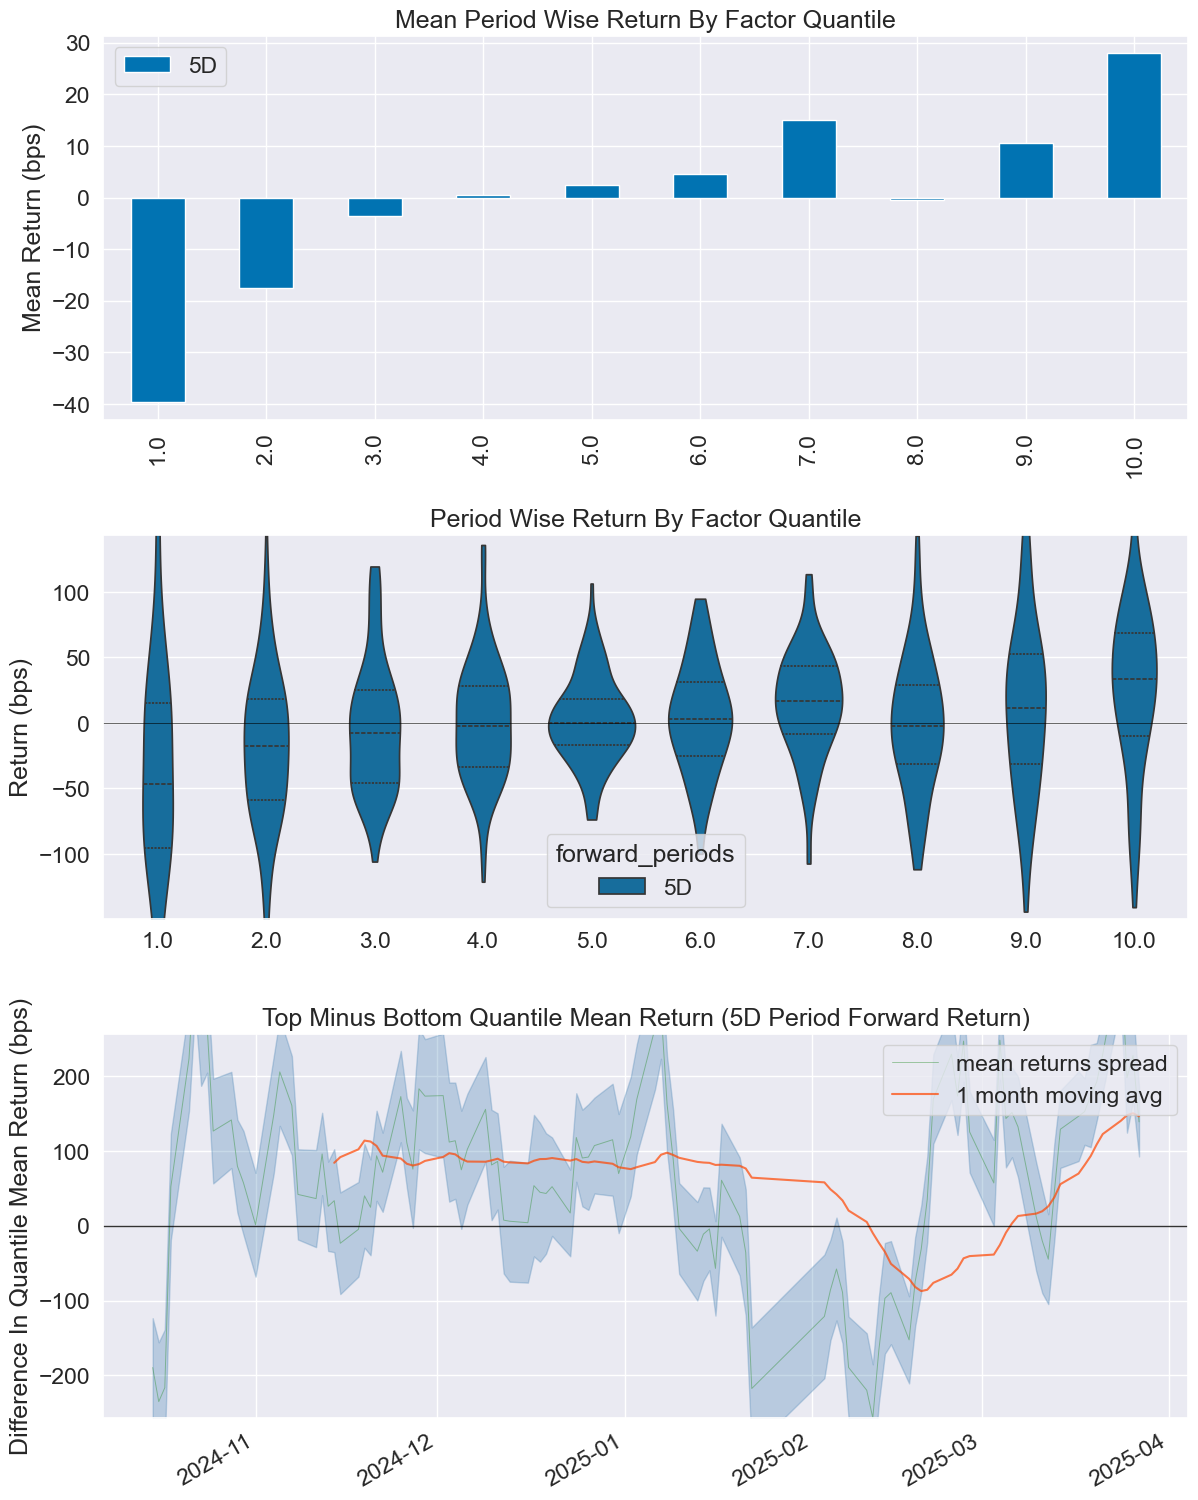

Information Analysis


,5D
IC Mean,0.067
IC Std.,0.110
Risk-Adjusted IC,0.605
t-stat(IC),NaN
p-value(IC),NaN
IC Skew,NaN
IC Kurtosis,NaN


C:\Users\dctp2025\.conda\envs\dc1\Lib\site-packages\alphalens\performance.py:118: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  grouper.append(pd.Grouper(freq=by_time))


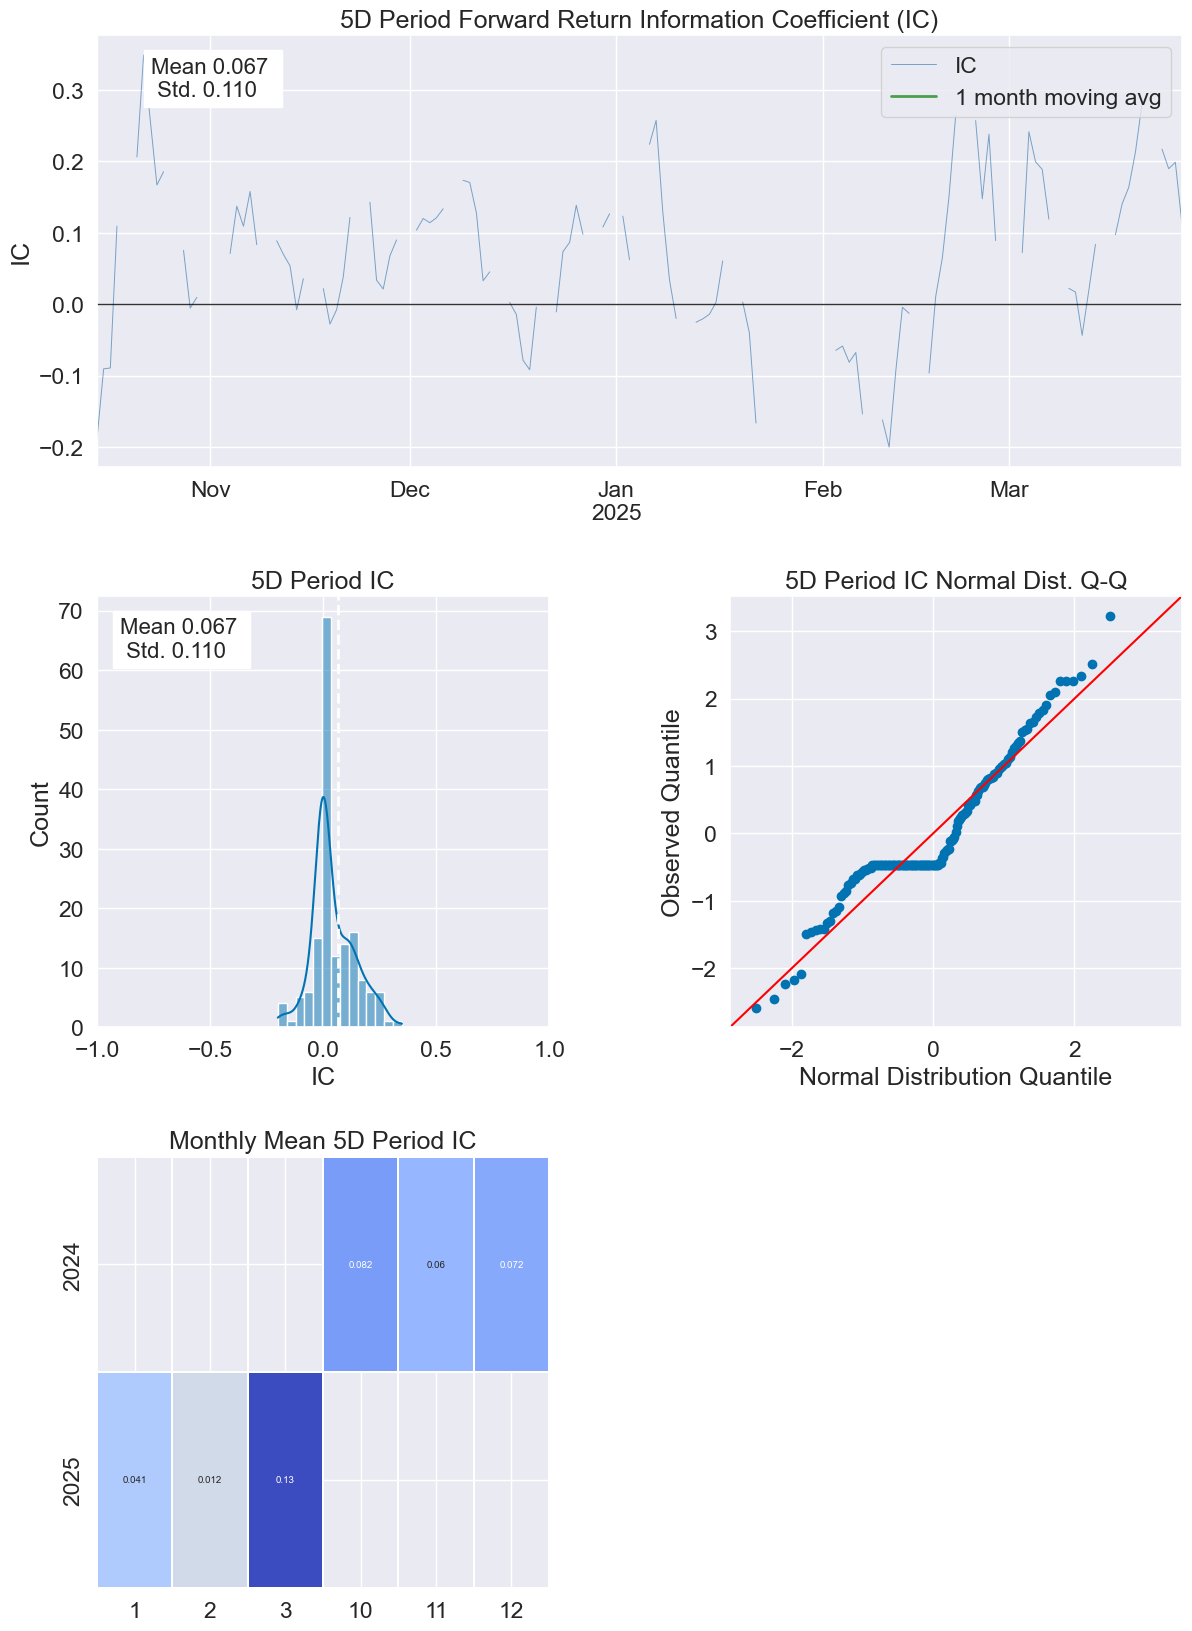

Turnover Analysis


C:\Users\dctp2025\.conda\envs\dc1\Lib\site-packages\alphalens\utils.py:928: UserWarning: Skipping return periods that aren't exact multiples of days.
  warnings.warn(


,5D
Quantile 1.0 Mean Turnover,0.341
Quantile 2.0 Mean Turnover,0.629
Quantile 3.0 Mean Turnover,0.713
Quantile 4.0 Mean Turnover,0.763
Quantile 5.0 Mean Turnover,0.779
Quantile 6.0 Mean Turnover,0.775
Quantile 7.0 Mean Turnover,0.742
Quantile 8.0 Mean Turnover,0.698
Quantile 9.0 Mean Turnover,0.628
Quantile 10.0 Mean Turnover,0.403


,5D
Mean Factor Rank Autocorrelation,0.743


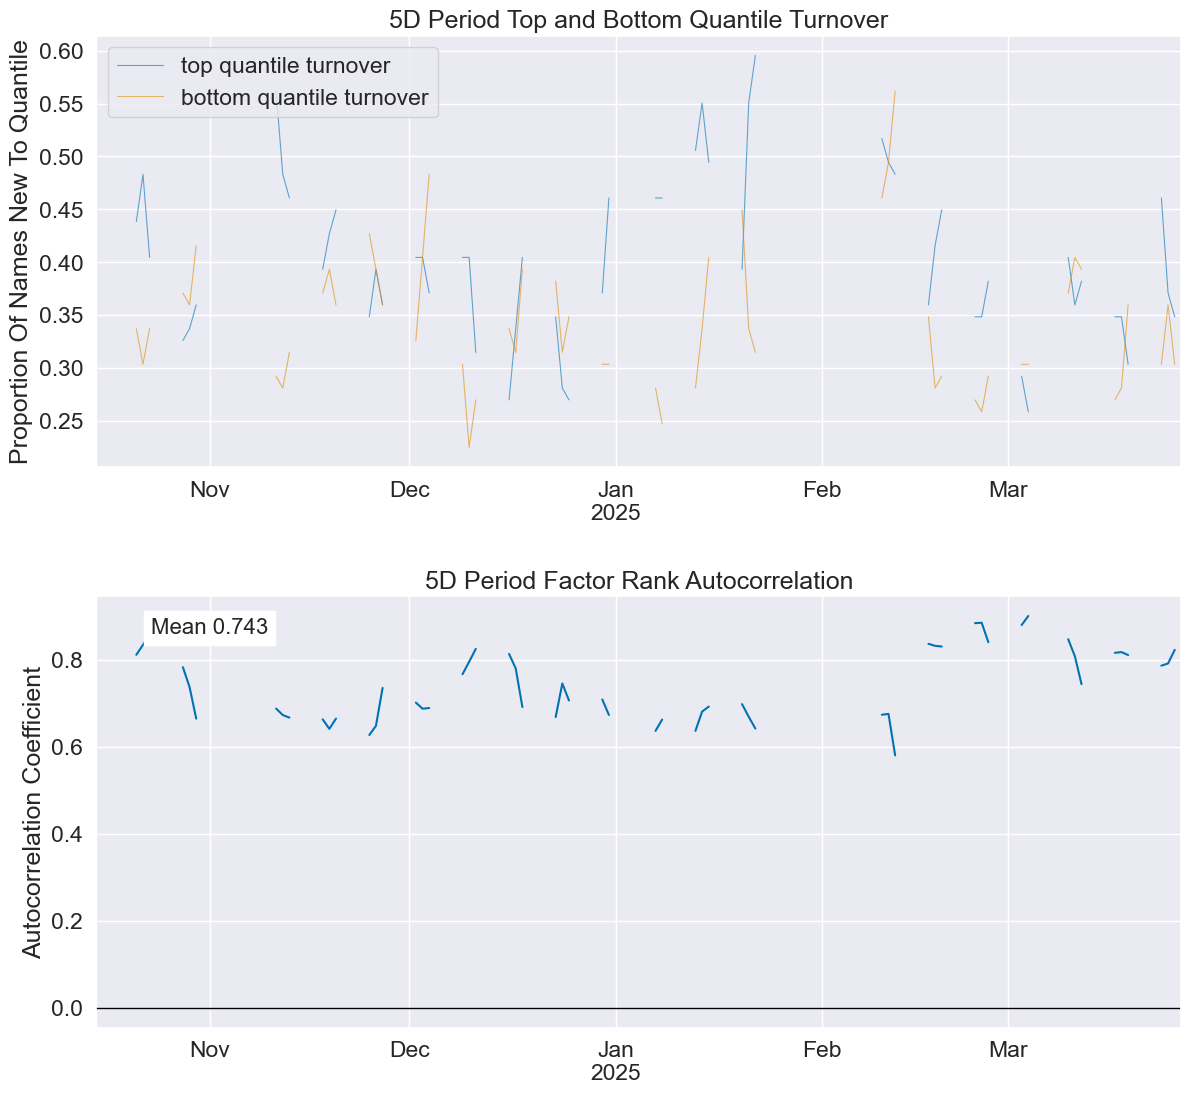

In [36]:
ic_smooth = ic_series.rolling(window=3).mean()
ic_smooth = ic_smooth.shift(5)
ic_smooth

date
2024-10-15         NaN
2024-10-16         NaN
2024-10-17         NaN
2024-10-18         NaN
2024-10-21         NaN
                ...   
2025-03-24    0.069669
2025-03-25    0.087829
2025-03-26    0.100052
2025-03-27    0.093072
2025-03-28    0.113468
Length: 109, dtype: float64

In [34]:
ic_smooth_shift = ic_smooth.shift(1).fillna(0)
ic_smooth_shift 

NameError: name 'ic_smooth' is not defined

In [35]:
score_df = pd.DataFrame(predicted_zscores_values, index=dates, columns=test_set.stock_list)
score_df_shift = score_df.shift(1).dropna()
score_df_shift.head(2)

ticker,1101,1102,1103,1104,1108,1109,1110,1201,1203,1210,...,9939,9940,9941,9942,9943,9944,9945,9946,9955,9958
Date,,,,,,,,,,,,,,,,,,,,,
2024-10-16,0.191162,0.264648,0.192261,0.044678,0.170044,-0.004807,0.214111,0.474365,0.213135,0.370605,...,0.196289,0.128784,0.041046,0.216553,0.238037,0.347412,0.132446,0.074829,0.129395,0.031586
2024-10-17,0.196289,0.316895,0.142456,0.001147,0.121460,-0.037933,0.382812,0.363037,0.194824,0.272217,...,0.131104,0.202148,0.016479,0.321777,0.199829,0.334473,0.155884,0.001734,0.064697,-0.164795


In [39]:
test_set.stock_list

Index(['1101', '1102', '1103', '1104', '1108', '1109', '1110', '1201', '1203',
       '1210',
       ...
       '9939', '9940', '9941', '9942', '9943', '9944', '9945', '9946', '9955',
       '9958'],
      dtype='object', name='ticker', length=887)

In [36]:
import matplotlib.pyplot as plt

In [39]:
topK_long = 30
topK_short = 30

select_prices = None
select_prices_long = None
select_prices_short = None

returns = np.zeros(len(score_df_shift.index))
returns_long = np.zeros(len(score_df_shift.index))
returns_short = np.zeros(len(score_df_shift.index))

last_ret = 0
last_ret_long = 0
last_ret_short = 0

#ic_bad = False

for idx, date in enumerate(score_df_shift.index):
    if idx%5==0:
        #ic_bad = False
        #if ic_smooth_shift.loc[date]<0:
        #    ic_bad = True


        
        last_ret = returns[idx-1] if idx > 0 else 0
        last_ret_long = returns_long[idx-1] if idx > 0 else 0
        last_ret_short = returns_short[idx-1] if idx > 0 else 0

        
        returns[idx] = last_ret
        returns_long[idx] = last_ret_long
        returns_short[idx] = last_ret_short
        
        _scores = score_df_shift.loc[date].values
        top_indices = np.argpartition(-_scores, topK_long)[:topK_long]         # 最大的 30 個索引（無排序）
        bottom_indices = np.argpartition(_scores, topK_short)[:topK_short]       # 最小的 30 個索引（無排序）
        all_indices = np.concatenate([top_indices, bottom_indices])
        
        select_prices = test_set.e.adj_close_df.loc[date].iloc[all_indices]
        select_prices_long = test_set.e.adj_close_df.loc[date].iloc[top_indices]
        select_prices_short = test_set.e.adj_close_df.loc[date].iloc[bottom_indices]
        
        
    else:
        current_prices = test_set.e.adj_close_df.loc[date][select_prices.index]
        current_prices_long = test_set.e.adj_close_df.loc[date][select_prices_long.index]
        current_prices_short = test_set.e.adj_close_df.loc[date][select_prices_short.index]

        
        rets = (current_prices - select_prices)/select_prices
        rets.iloc[topK_long:]*=(-1)
        
        rets_long = (current_prices_long - select_prices_long)/select_prices_long
        rets_short = (current_prices_short - select_prices_short)/select_prices_short
        
        
        
        returns[idx] = rets.mean() + last_ret #if not ic_bad else last_ret
        returns_long[idx] = rets_long.mean() + last_ret_long #if not ic_bad else last_ret_long
        returns_short[idx] = rets_short.mean()*(-1) + last_ret_short #if not ic_bad else last_ret_short



        
    

In [40]:
score_df_shift.index[:-2]

DatetimeIndex(['2024-10-16', '2024-10-17', '2024-10-18', '2024-10-21',
               '2024-10-22', '2024-10-23', '2024-10-24', '2024-10-25',
               '2024-10-28', '2024-10-29',
               ...
               '2025-03-21', '2025-03-24', '2025-03-25', '2025-03-26',
               '2025-03-27', '2025-03-28', '2025-03-31', '2025-04-01',
               '2025-04-02', '2025-04-07'],
              dtype='datetime64[ns]', name='Date', length=112, freq=None)

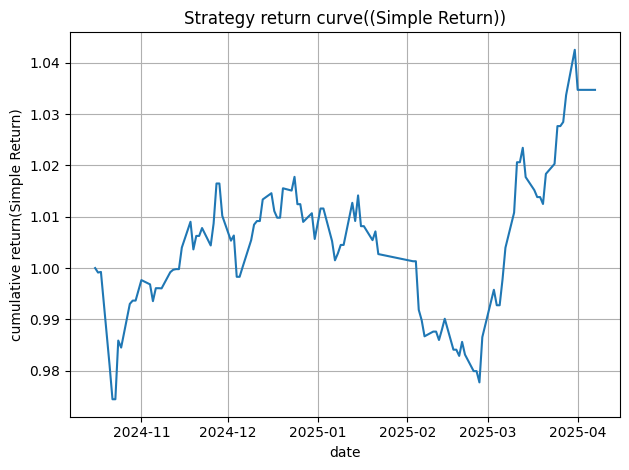

In [42]:
plt.plot(score_df_shift.index[:-2], 1 + returns[:-2])
plt.title("Strategy return curve((Simple Return))")  # 這裡加標題
plt.xlabel("date")
plt.ylabel("cumulative return(Simple Return)")
plt.grid(True)
plt.tight_layout()
plt.show()


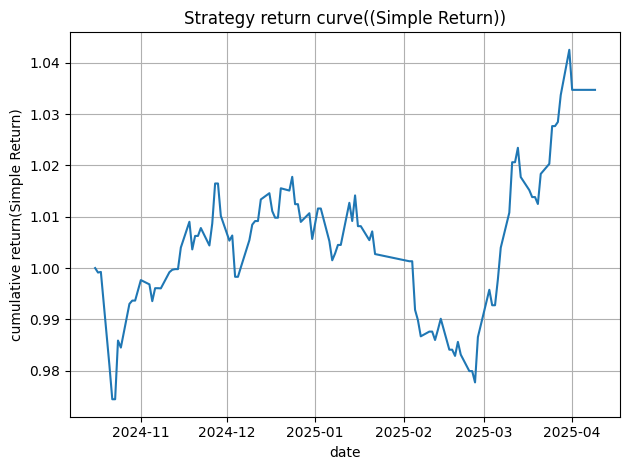

In [43]:
plt.plot(score_df_shift.index, 1 + returns)
plt.title("Strategy return curve((Simple Return))")  # 這裡加標題
plt.xlabel("date")
plt.ylabel("cumulative return(Simple Return)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [44]:
TAIEX_np = np.empty(len(score_df_shift.index))
for idx, date in enumerate(score_df_shift.index):
    str_date = date.date().strftime("%Y-%m-%d")
    df = pd.read_feather(rf'Z:\ticks_feather_TXF\{str_date}.ftr')
    TAIEX_np[idx] = df.iloc[-1]['close']

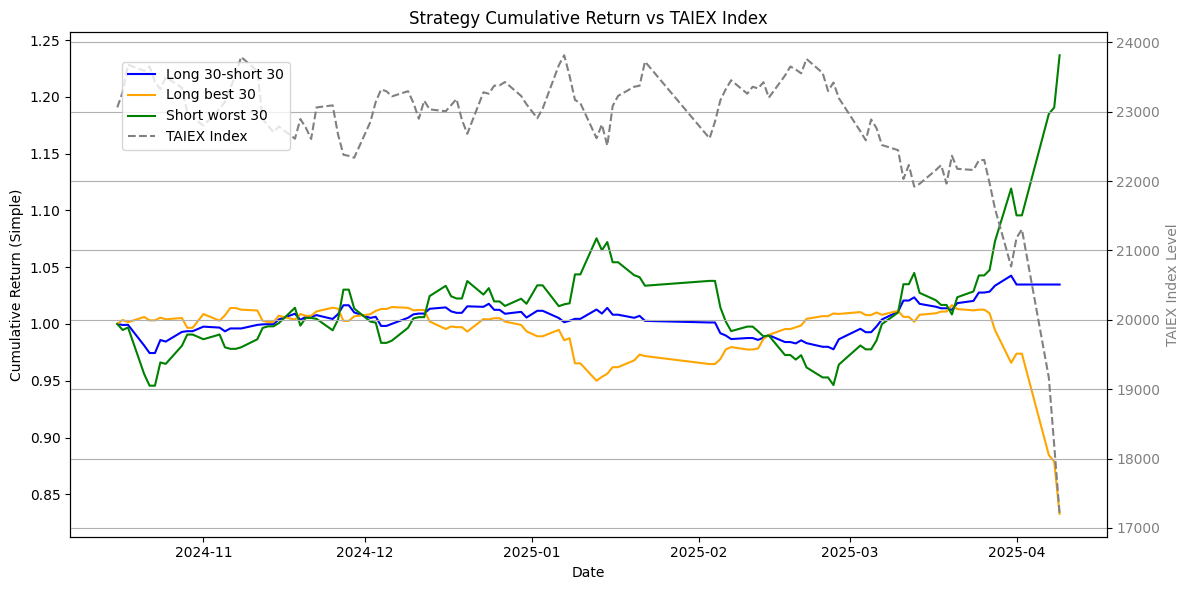

In [45]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 6))

# 畫策略報酬在左邊的 Y 軸
ax1.plot(score_df_shift.index, 1 + returns, color='blue', label='Long 30-short 30')
ax1.set_xlabel("Date")
ax1.set_ylabel("Cumulative Return (Simple)", color='black')
ax1.tick_params(axis='y', labelcolor='black')

# 畫策略報酬在左邊的 Y 軸
ax1.plot(score_df_shift.index, 1 + returns_long, color='orange', label='Long best 30')
ax1.set_xlabel("Date")
ax1.set_ylabel("Cumulative Return (Simple)", color='black')
ax1.tick_params(axis='y', labelcolor='black')

# 畫策略報酬在左邊的 Y 軸
ax1.plot(score_df_shift.index, 1 + returns_short, color='green', label='Short worst 30')
ax1.set_xlabel("Date")
ax1.set_ylabel("Cumulative Return (Simple)", color='black')
ax1.tick_params(axis='y', labelcolor='black')

"""
# 畫策略報酬在左邊的 Y 軸
ax1.plot(score_df_shift.index, 1 + (returns_long+returns_short)/2, color='brown', label='XXXXX')
ax1.set_xlabel("Date")
ax1.set_ylabel("Cumulative Return (Simple)", color='black')
ax1.tick_params(axis='y', labelcolor='black')
"""



# 建立右邊 Y 軸
ax2 = ax1.twinx()
ax2.plot(score_df_shift.index, TAIEX_np, color='gray', linestyle='--', label='TAIEX Index')
ax2.set_ylabel("TAIEX Index Level", color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

# 加標題和圖例
plt.title("Strategy Cumulative Return vs TAIEX Index")
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

plt.grid(True)
plt.tight_layout()
plt.show()


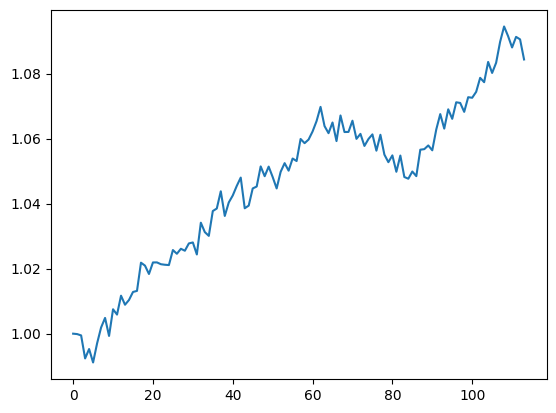

In [91]:
return_series = np.zeros((5, len(score_df_shift.index)))
topK_long = 30
topK_short = 30
select_prices = None

for i in range(5):
    last_ret = None
    for j in range(i, len(score_df_shift)):
        date = score_df_shift.index[j]
        
        if j%5==i: # buy time
            last_ret = return_series[i, j - 1] if j > 0 else 0
            
            _scores = score_df_shift.loc[date].values
            top_indices = np.argpartition(-_scores, topK_long)[:topK_long]         # 最大的 30 個索引（無排序）
            bottom_indices = np.argpartition(_scores, topK_short)[:topK_short]       # 最小的 30 個索引（無排序）
            all_indices = np.concatenate([top_indices, bottom_indices])
            select_prices = test_set.e.adj_close_df.loc[date].iloc[all_indices]
        else:
            current_prices = test_set.e.adj_close_df.loc[date][select_prices.index]
            rets = (current_prices - select_prices)/select_prices
            rets.iloc[topK_long:]*=(-1)
            return_series[i, j]=last_ret + rets.mean()

cum_list = np.mean(return_series, axis=0)
plt.plot(1+cum_list)
            
        
    

In [92]:
np.mean(returns)

np.float64(0.05610260505794055)

2024-10-15 00:00:00


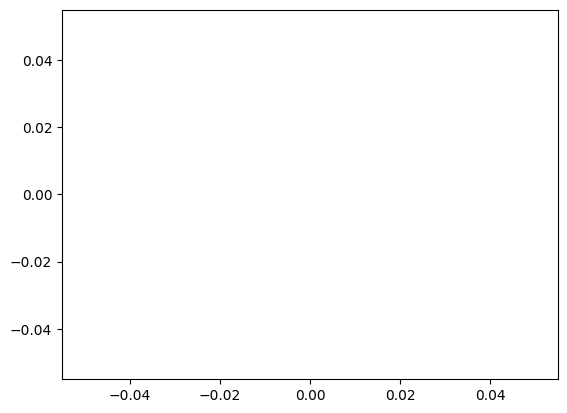

In [93]:

topK_long = 30
topK_short = 30
select_prices = None

#returns = np.zeros(len(score_df_shift.index))
r_list = []
for idx, date in enumerate(score_df.index):
    print(date)
    break
    if idx==109:
        break
    _scores = score_df.loc[date].values
    top_indices = np.argpartition(-_scores, topK_long)[:topK_long]         # 最大的 30 個索引（無排序）
    bottom_indices = np.argpartition(_scores, topK_short)[:topK_short]       # 最小的 30 個索引（無排序）
    all_indices = np.concatenate([top_indices, bottom_indices])


    date_position = test_set.e.adj_close_df.index.get_loc(date)

    select_prices = test_set.e.adj_close_df.iloc[date_position+1].iloc[all_indices]
    current_prices = test_set.e.adj_close_df.iloc[date_position+4][select_prices.index]
    #print(select_prices)
    #print(current_prices)
    rets = (current_prices - select_prices)/select_prices
    rets.iloc[topK_long:]*=(-1)
    r_list.append(rets.mean())



        
plt.plot(np.cumsum(r_list))

In [158]:
score_df_shift

ticker,1101,1102,1103,1104,1108,1109,1110,1201,1203,1210,...,9939,9940,9941,9942,9943,9944,9945,9946,9955,9958
Date,,,,,,,,,,,,,,,,,,,,,
2024-10-16,-0.017830,-0.015456,-0.017123,-0.022213,-0.013404,-0.019217,-0.013603,-0.015855,-0.154132,-0.014855,...,-0.019266,-0.034742,-0.187932,-0.074042,-0.018216,-0.014595,-0.014677,-0.223690,-0.108817,-0.245812
2024-10-17,-0.019765,-0.015537,-0.017545,-0.022466,-0.013842,-0.018469,-0.009489,-0.016467,-0.063927,-0.022693,...,-0.017175,-0.016570,-0.167494,-0.016887,-0.020612,-0.013394,-0.011834,-0.228777,-0.148851,-0.247885
2024-10-18,-0.020143,-0.017093,-0.019819,-0.020703,-0.019453,-0.019185,-0.014047,-0.018466,-0.064532,-0.020119,...,-0.019772,-0.017379,-0.151925,-0.017214,-0.020835,-0.017741,-0.015189,-0.240812,-0.207839,-0.245818
2024-10-21,-0.017178,-0.013067,-0.017601,-0.018379,-0.017742,-0.017050,-0.010453,-0.018661,-0.052486,-0.016205,...,-0.016119,-0.014483,-0.175785,-0.015414,-0.019288,-0.016348,-0.011336,-0.225132,-0.171028,-0.249835
2024-10-22,-0.019535,-0.011490,-0.015832,-0.016328,-0.014082,-0.015464,-0.009408,-0.016670,-0.014797,-0.017634,...,-0.018384,-0.015590,-0.108713,-0.026665,-0.014915,-0.022896,-0.010336,-0.234471,-0.212326,-0.251250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-01,-0.045282,-0.018348,-0.115274,-0.046830,-0.041240,-0.064940,-0.112352,-0.046065,-0.038760,-0.035628,...,-0.047287,-0.142267,-0.077245,-0.042115,-0.048437,-0.110858,-0.057689,-0.186854,-0.151085,-0.084005
2025-04-02,-0.028601,-0.004376,-0.110493,-0.036567,-0.033948,-0.062360,-0.092685,-0.032375,-0.019137,-0.013275,...,-0.033314,-0.162391,-0.071372,-0.109970,-0.065232,-0.082024,-0.030544,-0.168610,-0.152449,-0.042919
2025-04-07,-0.033781,-0.019781,-0.111696,-0.046997,-0.063540,-0.059016,-0.054118,-0.134958,-0.025108,-0.020957,...,-0.033484,-0.158528,-0.090863,-0.152666,-0.110247,-0.067465,-0.032299,-0.173697,-0.167007,-0.033924


In [159]:
score_df_shift.shift(-3)-score_df_shift.shift(-1)

ticker,1101,1102,1103,1104,1108,1109,1110,1201,1203,1210,...,9939,9940,9941,9942,9943,9944,9945,9946,9955,9958
Date,,,,,,,,,,,,,,,,,,,,,
2024-10-16,0.002587,0.002470,-0.000056,0.004087,-0.003900,0.001418,-0.000965,-0.002194,0.011441,0.006488,...,0.001056,0.002087,-0.008290,0.001473,0.001324,-0.002954,0.000499,0.003645,-0.022176,-0.001950
2024-10-17,0.000608,0.005603,0.003987,0.004375,0.005371,0.003721,0.004639,0.001797,0.049734,0.002485,...,0.001388,0.001789,0.043212,-0.009451,0.005920,-0.005154,0.004853,0.006341,-0.004487,-0.005432
2024-10-18,-0.005458,-0.004051,-0.002105,-0.000635,-0.000753,-0.002207,-0.007220,-0.002524,0.023594,-0.004913,...,-0.006915,-0.016743,0.077078,-0.019923,0.000446,-0.010535,-0.006757,-0.001836,-0.045081,-0.001145
2024-10-21,-0.001310,-0.005030,-0.002342,-0.002815,-0.004397,-0.003191,-0.008018,-0.002821,-0.028449,-0.003239,...,-0.007354,-0.017363,0.022931,-0.021620,-0.004140,-0.004747,-0.007406,0.013799,-0.002737,0.001495
2024-10-22,0.006353,0.006069,0.005729,0.003086,0.004102,0.005954,0.004575,0.003120,-0.009223,0.002831,...,0.007475,-0.008992,0.032894,-0.013014,-0.000427,-0.004634,0.004903,0.042855,0.118963,0.010315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-01,-0.001461,-0.015226,0.036101,0.001533,-0.027634,0.017130,0.024944,-0.102612,-0.011527,-0.007975,...,-0.009926,0.001802,-0.048715,-0.021681,-0.026575,0.023918,-0.018375,-0.013663,0.002338,0.000642
2025-04-02,0.001416,-0.005122,0.045841,0.010864,0.004650,0.008521,0.009455,-0.010304,-0.008265,-0.008326,...,-0.004478,0.015348,0.009318,0.038420,0.006805,0.013644,-0.005175,0.012794,0.021785,-0.008584
2025-04-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
